## 23_04_24_03_erythroid_lineage_速率估计

In [1]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

## 1. 数据读入

In [3]:
# 红系成熟部分
adata = scv.read("/mnt/h/F_bak/PyCode/xijing/notebook/data/Gastrulation/erythroid_lineage.h5ad")
sc.pp.subsample(adata, n_obs=500)
batch_key = "stage"
cluster_key = "celltype"
adata

AnnData object with n_obs × n_vars = 500 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

## 2. 预处理

In [4]:
batch_pair_list = None
batch_pair_list = [
    ["E7.0", "E7.25"],
    ["E7.25", "E7.5"],
    ["E7.5", "E7.75"],
    ["E7.75", "E8.0"],
    ["E8.0", "E8.25"],
    ["E8.25", "E8.5"],
]

In [5]:
knn_mask, bnn_mask, subsample_adata = velovgi.pp.preprocess(adata, sample_mode="random", batch_key=batch_key, batch_pair_list=batch_pair_list)

Filtered out 51490 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
calculating knn and bnn mask...
pair_list : [['E7.0', 'E7.25'], ['E7.25', 'E7.5'], ['E7.5', 'E7.75'], ['E7.75', 'E8.0'], ['E8.0', 'E8.25'], ['E8.25', 'E8.5']]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


smoothing...
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 3. 默认参数执行VELOVGI并恢复可视化

In [6]:
seed_everything(seed)

In [7]:
velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
velovgi_model = velovgi.tl.VELOVGI(subsample_adata)
velovgi_model.train()
# velovgi_model.train(max_epochs=20)

初始训练，初始化runner参数
choosing neighbor minibatch


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [03:47<00:00,  2.48it/s, loss=1.43e+04, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [03:47<00:00,  2.20it/s, loss=1.43e+04, v_num=1]


In [8]:
velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, velovgi_model)
subsample_adata

AnnData object with n_obs × n_vars = 250 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: 'celltype_colors', 'neighbors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocity_u', 'latent_time_velovi', 'fit_t'
    obsp: 'distances', 'connectivities'

In [9]:
# velovgi.pp.moment_layer_attribute(adata, subsample_adata, "velocity")
# velovgi.pp.moment_layer_attribute(adata, subsample_adata, "velocity_u")
# velovgi.pp.moment_layer_attribute(adata, subsample_adata, "fit_t")
velovgi.pp.moment_recover(adata, subsample_adata)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/12 cores)


/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


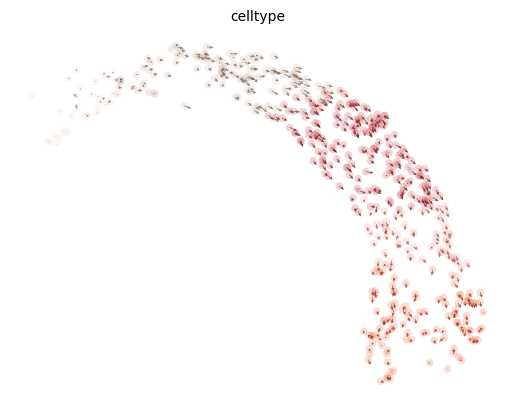

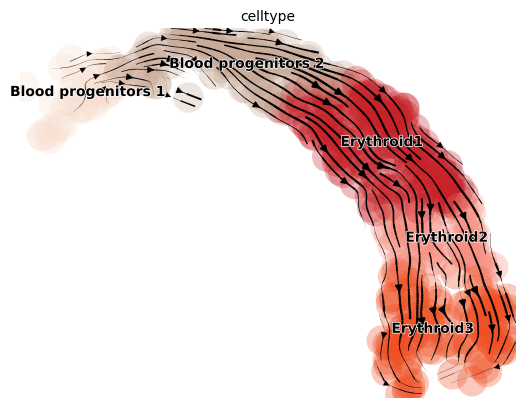

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'sample_recover', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocity_u', 'fit_t'
    obsp: 'distances', 'connectivities'

In [10]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding(adata, color=cluster_key)
scv.pl.velocity_embedding_stream(adata, color=cluster_key)
adata

## 4. 指标计算

In [11]:
label = cluster_key
# 已知的细胞类型间的分化信息
cluster_edges = [
    ("Blood progenitors 1", "Blood progenitors 2"), 
    ("Blood progenitors 2", "Erythroid1"), 
    ("Erythroid1", "Erythroid2"), 
    ("Erythroid2", "Erythroid3")
    ]
adata_velo = velovgi.tl.pre_metric(adata, "velocity")
exp_metrics = velovgi.tl.summary_metric(adata_velo, cluster_edges, label, k_batch=batch_key, return_raw=True)

## 5. 结果保存

1. subsample_adata保存

In [12]:
subsample_adata.write("./tmp/erythroid_lineage2/subsample_adata.h5ad")

2. adata对象保存

In [13]:
# adata_dir = "tmp/erythroid_lineage/adata"
adata_dir = "tmp/erythroid_lineage2/adata"
velovgi.tl.write_adata(adata, adata_dir)
adata = velovgi.tl.read_adata(adata_dir)

create tmp/erythroid_lineage2/adata
save tmp/erythroid_lineage2/adata/sample_recover.pkl
save tmp/erythroid_lineage2/adata/adata.h5ad
load tmp/erythroid_lineage2/adata/adata.h5ad
load tmp/erythroid_lineage2/adata/sample_recover.pkl


2. 模型保存

In [14]:
# model_dir = "tmp/erythroid_lineage/model"
model_dir = "tmp/erythroid_lineage2/model"
velovgi_model.save(model_dir)